In [13]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [14]:
def build_generator():
  noise_shape = (100,)

  model = Sequential()

  model.add(Dense(256, input_shape = noise_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(512, input_shape = noise_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(1024, input_shape = noise_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(256, input_shape = noise_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(BatchNormalization(momentum = 0.8))

  model.add(Dense(np.prod(img_shape), activation = 'tanh'))
  model.add(Reshape(img_shape))

  model.summary()

  noise = Input(shape = noise_shape)
  #print(noise)
  img = model(noise)
  #print(img)
  return Model(noise, img)

In [15]:
def build_discriminator():

  model = Sequential()

  model.add(Flatten(input_shape = img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(1, activation = 'sigmoid'))
  model.summary()

  img = Input(shape = img_shape)
  #print(img)
  validity = model(img)
  #print(validity)
  return Model(img, validity)
  #Model return input & output sizes of model.

In [27]:
def train(epochs, batch_size = 128, save_interval = 100):
  (X_train, _), (_,_) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5

  X_train = np.expand_dims(X_train, axis = 3)
  half_batch = int(batch_size / 2)

  for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0,1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    #From input(100,) to output(28*28) of 64 datas

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))

    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)

    g_loss = combined.train_on_batch(noise, valid_y)

    #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    if epoch % save_interval == 0:
      save_imgs(epoch)

In [28]:
def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0,1, (r * c, 100))
  gen_imgs = generator.predict(noise)

  #Rescale images 0-1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r,c)
  cnt = 0

  for i in range(r):
    for j in range(c):

      axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

  fig.savefig("/content/drive/MyDrive/GAN_2/f_2/mnist_%d.png" % epoch)
  plt.close()
  import cv2
  import imutils
  image =  cv2.imread(r"/content/drive/MyDrive/GAN_2/f_2/mnist_%d.png" % epoch)
  from google.colab.patches import cv2_imshow
  cv2_imshow(image)

#This function saves our images for us to view

In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = optimizer,
                      metrics = ['accuracy'])

#build and compile our Discrimator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images
z = Input(shape = (100,))
img = generator(z)


#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.
discriminator.trainable = False


#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.

valid = discriminator(img) #Validity check on the generated image

#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)

train(epochs = 50000, batch_size = 32, save_interval = 100)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5') #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.





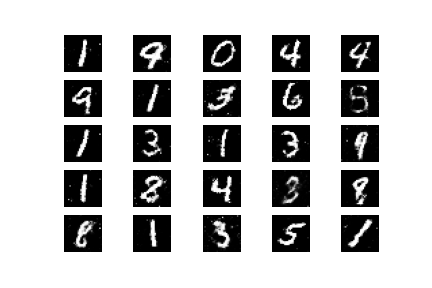

In [46]:
import cv2
import imutils
image =  cv2.imread(r"/content/drive/MyDrive/GAN_2/f_2/mnist_%d.png" % 44900)
from google.colab.patches import cv2_imshow
cv2_imshow(image)